In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

from astropy.io import fits
import scipy
import pymaster as nmt

In [3]:
f0, f1 = '143', '143'
split0, split1 = '1', '2'
lmax = 2508
nside = 2048
lmax_beam = 3*nside # beam needs to extend to high enough ell for NaMaster

In [4]:
def get_bonus_bins(width=5, top_ell=30, l_min=2):
    bonus_bin_left, bonus_bin_right = [], []
    counter = 0
    for i in list(range(1,top_ell))[::-1]:
        counter += 1
        if i == l_min:
            bonus_bin_left.append(i)
            bonus_bin_right.append(i+width-1)
            break
        elif counter % width == 0:
            bonus_bin_left.append(i)
            bonus_bin_right.append(i+width-1)
    return bonus_bin_left[::-1], bonus_bin_right[::-1]

In [5]:
! pwd

/home/zequnl/Installs/PSpipe/project/Planck/notebooks


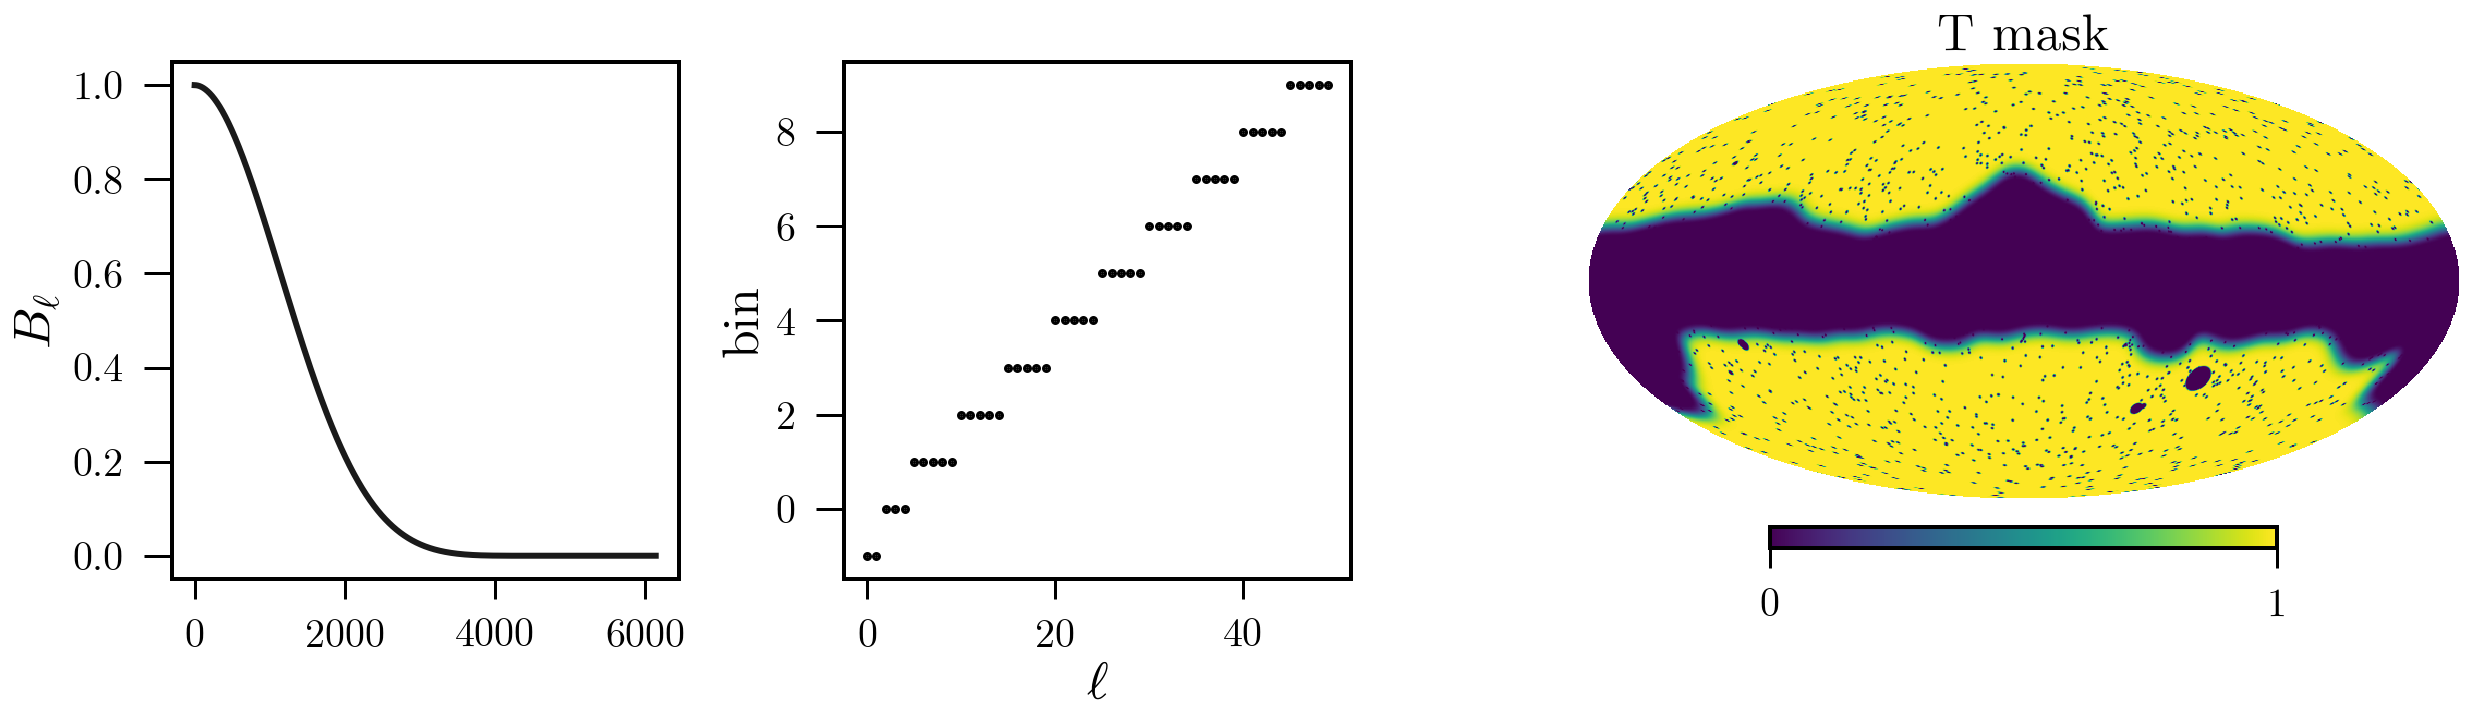

In [6]:
beam_filename = f'../planck_beam/beam_probably_used_in_2015_likelihood_{f0}hm1x{f1}hm2.dat.dat'
beam_ell, beam = np.genfromtxt(beam_filename, unpack=True) # beam file is ell, Bl
Bl = np.zeros(lmax_beam)
Bl[beam_ell.astype(int)] = beam

binleft, binright = np.genfromtxt('../planck_spectra/binused.dat', 
                                  unpack=True, usecols=(0,1), dtype=((int), (int)))
bonus_left, bonus_right = get_bonus_bins(5, l_min=2)
binleft, binright = np.hstack((bonus_left,binleft)), np.hstack((bonus_right,binright))
    
ells = np.arange(lmax+1)
bpws = -1+np.zeros_like(ells) #Array of bandpower indices
for i, (bl, br) in enumerate(zip(binleft, binright)):
    bpws[bl:br+1] = i
weights = np.array([1 / np.sum(bpws == bpws[l]) for l in ells])
b = nmt.NmtBin(nside, bpws=bpws, ells=ells, weights=weights, lmax=lmax, is_Dell=False)
lb = b.get_effective_ells()

mask0t = hp.read_map(f'../masks/COM_Mask_Likelihood-temperature-{f0}_2048_R2.00.fits', verbose=False)
mask1t = hp.read_map(f'../masks/COM_Mask_Likelihood-temperature-{f1}_2048_R2.00.fits', verbose=False)

fig, ax = plt.subplots(1, 3, figsize=(18,5), gridspec_kw = {'width_ratios':[1, 1, 2]})
ax[0].plot( np.arange(lmax_beam), Bl)
ax[0].set_ylabel(r"$B_{\ell}$")
ax[1].plot(bpws[:50], 'k.')
ax[1].set_ylabel('bin')
ax[1].set_xlabel(r'$\ell$')
fig.tight_layout()

plt.sca(ax[2])
hp.mollview(mask0t, hold=True, title='T mask')

We look in the `II_COV` (4th column of the frequency maps) for the variance on the I stokes map. The unobserved/missing pixels are marked as the healpix missing value, which is something like -1.6e30. We then set these to zero in the maps and mask, for each split (there are big differences between splits!).

In [7]:
c0_file = f'../maps/PR2/frequencyMaps/HFI_SkyMap_{f0}_2048_R2.02_halfmission-{split0}.fits'
c1_file = f'../maps/PR2/frequencyMaps/HFI_SkyMap_{f1}_2048_R2.02_halfmission-{split1}.fits'
cov0 = hp.read_map(c0_file, field=4, verbose=False) # II_COV
cov1 = hp.read_map(c1_file, field=4, verbose=False) # II_COV

badpix0 = (cov0<-1e30)
badpix1 = (cov1<-1e30)

m0_file = f'../maps/PR2/frequencyMaps/HFI_SkyMap_{f0}_2048_R2.02_halfmission-{split0}.fits'
m1_file = f'../maps/PR2/frequencyMaps/HFI_SkyMap_{f1}_2048_R2.02_halfmission-{split1}.fits'
map0 = hp.read_map(m0_file, field=0, verbose=False) # I
map1 = hp.read_map(m1_file, field=0, verbose=False) # I

map0[badpix0] = 0.0
map1[badpix1] = 0.0
mask0t[badpix0] = 0.0
mask1t[badpix1] = 0.0

/home/zequnl/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


We need to correct for the pixel window, thee beam, and the mode coupling!

In [8]:
pixel_window = hp.sphtfunc.pixwin(nside, pol=False)[:lmax_beam]

In [9]:
hp.write_map('../window0.fits', mask0t, overwrite=True)
hp.write_map('../window1.fits', mask1t, overwrite=True)

hp.write_map('../map0.fits', map0, overwrite=True)
hp.write_map('../map1.fits', map1, overwrite=True)

In [10]:
import ispice

In [11]:
ispice.ispice(mapin1='../map0.fits', weightfile1='../window0.fits',
              mapfile2='../map1.fits', weightfile2='../window1.fits',
              subdipole='YES', subav='YES', nlmax=3100,
              clout='cl.fits')

Submitting job 0
/home/zequnl/Installs/PolSpice_v03-05-01/bin/./spice -apodizesigma NO -apodizetype 0 -beam NO -beam2 NO -clfile cl.fits -decouple NO -mapfile ../map0.fits -mapfile2 ../map1.fits -fits_out YES -weightfile ../window0.fits -weightfile2 ../window1.fits -nlmax 3100 -normfac 1.00000 -npairsthreshold 0.00000 -overwrite YES -polarization NO -pixelfile YES -pixelfile2 YES -subav YES -subdipole YES -symmetric_cl NO -thetamax NO -tolerance NO -verbosity 2 -weightpower 1.0 -weightpower2 1.0 -weightpowerp 1.0 -weightpowerp2 1.0 


0

In [12]:
fits.open('cl.fits')[1].data['TT'].shape

(3101,)

In [13]:
from astropy.io import fits
pixwin = hp.sphtfunc.pixwin(nside)
rawcl = fits.open('cl.fits')[1].data['TT'] / Bl[:3101]**2

In [14]:
binleft, binright = np.genfromtxt('../planck_spectra//binused.dat', 
                                          unpack=True, usecols=(0,1), dtype=((int), (int)))

binleft, binright = binleft, binright
ells = np.arange(len(rawcl))
bpws = -1+np.zeros_like(ells) #Array of bandpower indices
for i, (bl, br) in enumerate(zip(binleft, binright)):
    bpws[bl:br+1] = i
    
binned_ell = np.array([ np.sum(ells[bpws==bp])/np.sum(bpws==bp)
                       for bp in range(len(binleft)) ])

Cb_polspice = np.array([ np.sum(
        rawcl[bpws==bp]) / np.sum(bpws==bp) 
                          for bp in range(len(binleft)) ])

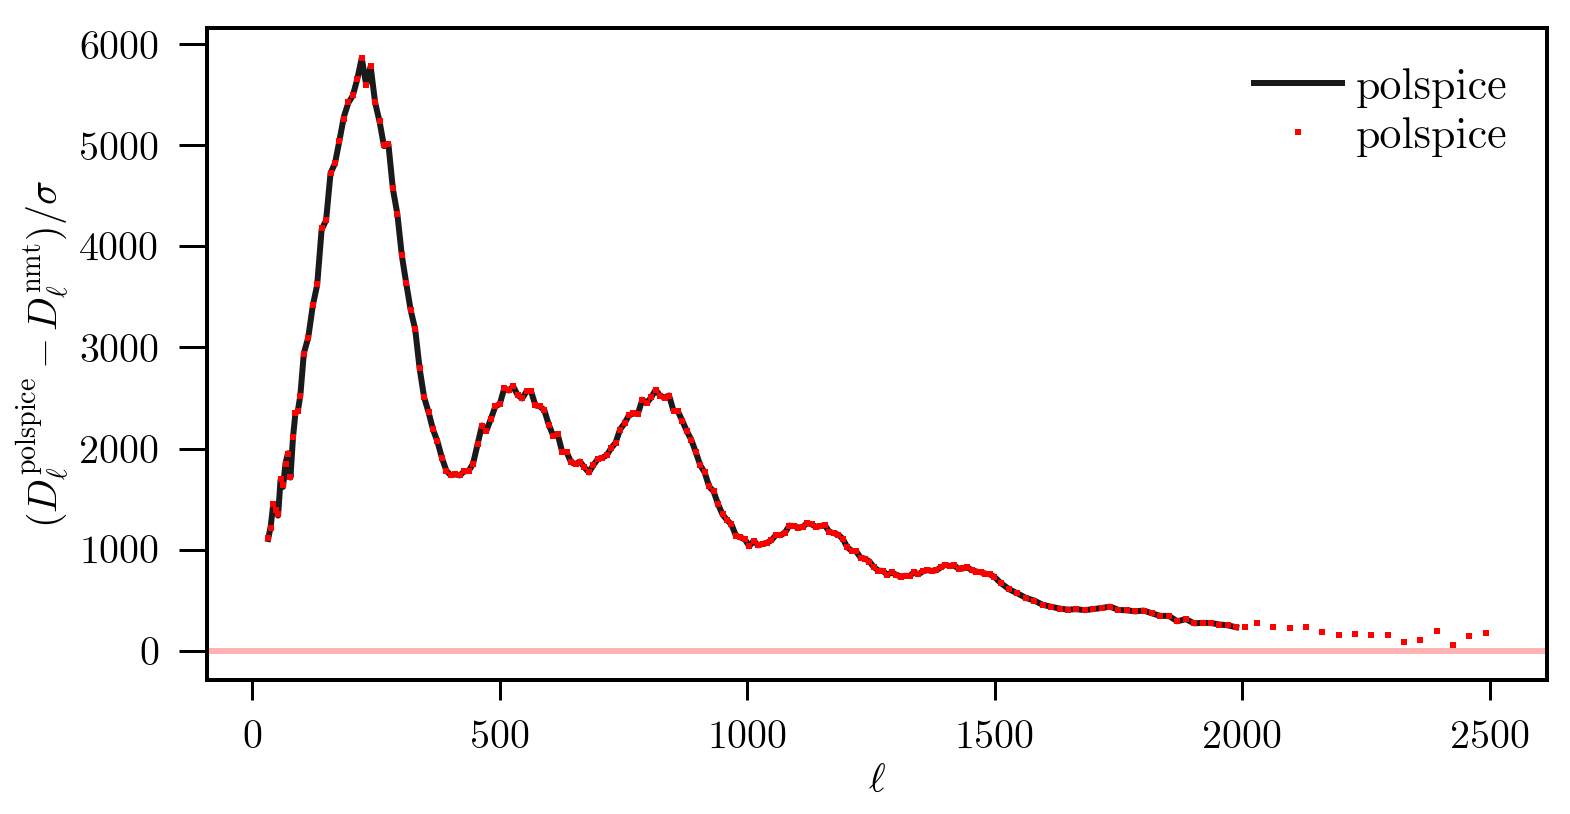

In [18]:
plt.figure(figsize=(12,6))
plt.axhline(0, color='red', alpha=0.3)
plt.ylabel(r'$(D_{\ell}^{\mathrm{polspice}} - D^{\rm nmt}_{\ell}) / \sigma$',fontsize=20)
plt.xlabel(r'$\ell$',fontsize=20)

lmin_,lmax_,l,cl,error=np.loadtxt('../planck_spectra/spectra_' + f'TT_{143}x{143}' + '.dat',unpack=True)

plt.plot(l,
         (cl) * l**2 / 2 /np.pi, label='polspice')

plt.plot(binned_ell,Cb_polspice*binned_ell**2/(2*np.pi) * 1e12, 'r.', marker='+', label='polspice')

# plt.ylim(-3, 3)
plt.legend()

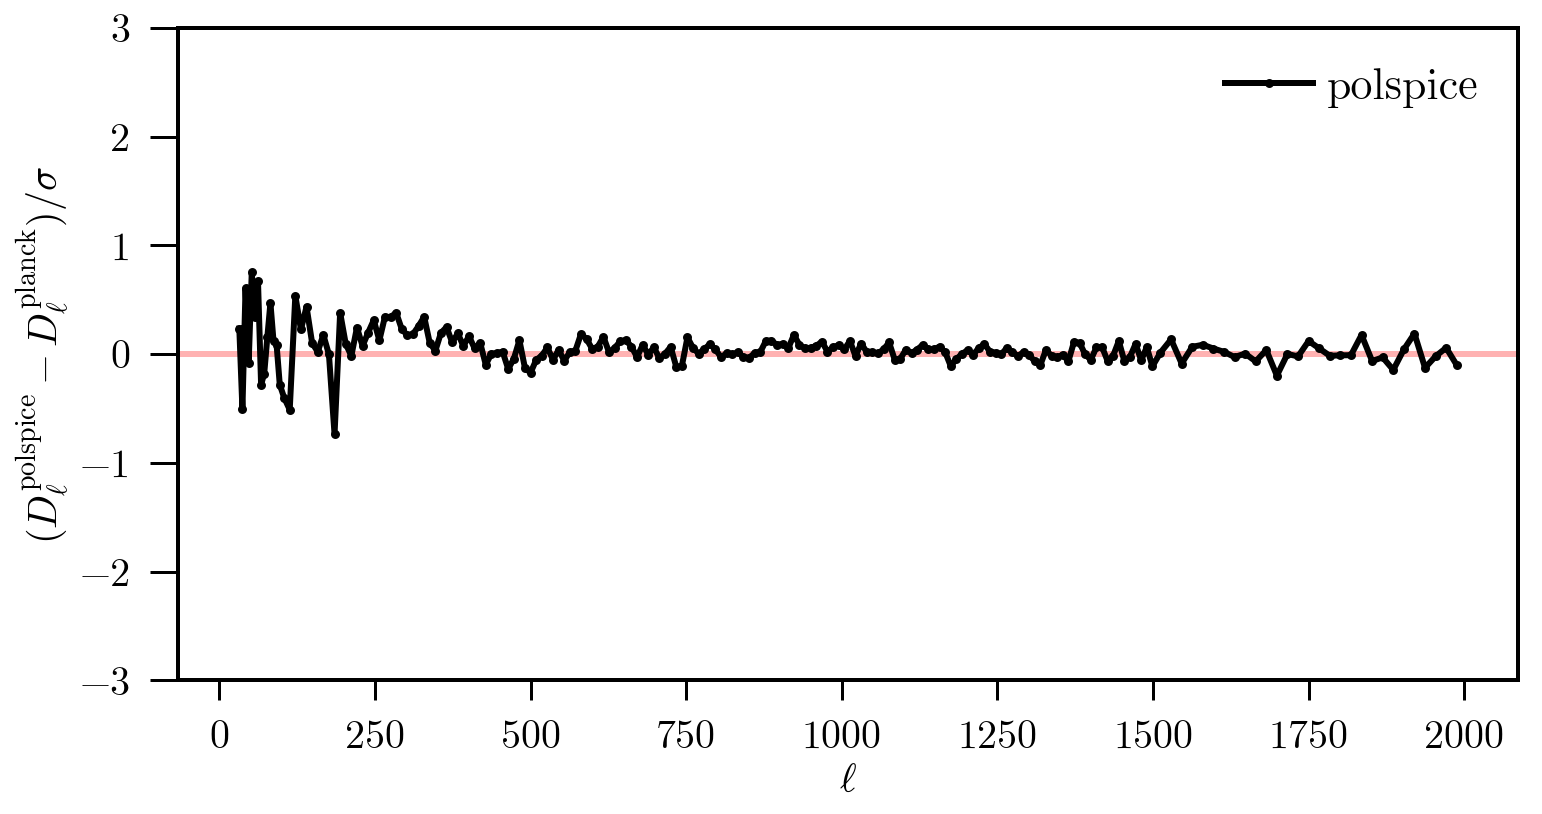

In [20]:
plt.figure(figsize=(12,6))
plt.axhline(0, color='red', alpha=0.3)
# plot the fractional difference
# plt.plot(lb_pspy,(Cb_pspy-Cb_namaster[0][:100])/Cb_namaster[0][:100], label='pspy')
plt.ylabel(r'$(D_{\ell}^{\mathrm{polspice}} - D^{\rm planck}_{\ell}) / \sigma$',fontsize=20)
plt.xlabel(r'$\ell$',fontsize=20)

lmin_,lmax_,l,cl,error=np.loadtxt('../planck_spectra/spectra_' + f'TT_{143}x{143}' + '.dat',unpack=True)
# plot the fractional difference
plt.plot(l,
         (Cb_polspice[:-16]*1e12
          -cl) / error, 'k.-', label='polspice')

plt.ylim(-3, 3)
plt.legend()